In [4]:
import matplotlib.pyplot as plt

import numpy as np
import time
import itertools
import scipy.stats as stats

from ProbabilisticDiffusion import Diffusion
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import sys

In [2]:
def tweedies(data, dist, plot_grad=True, plot_density=True, plot_tweedies=True, min_val=-0.5, max_val=0.5):
    # Tweedies formula
    covariance = np.cov(data.numpy().T)
    with tf.GradientTape() as tape:
        tape.watch(data)
        prob = dist.prob(data)
        gradients = tape.gradient(prob, data)
    
    gradients = gradients.numpy()
    prob = prob.numpy()
    prob_div = prob.reshape((len(gradients), 1))
    tweedies = data.numpy() + np.clip((covariance @ (gradients / prob_div).T).T, min_val, max_val) #Clip quotient for stability
    # Plot flags
    if plot_grad:
        sum_grads = np.sum(gradients, axis=1)
        plt.scatter(data[:,0], data[:,1], c=np.clip(sum_grads, min_val, max_val), s=7 , cmap='Spectral')
        plt.title('Gradients')
        cbar = plt.colorbar()
        plt.show()
    if plot_density:
        plt.scatter(data[:,0], data[:,1], c=prob, s=7 , cmap='Spectral')
        plt.title('Density')
        cbar = plt.colorbar()
        plt.show()
    if plot_tweedies:
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((gradients/prob_div).T, min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Quotient Term')
        cbar = plt.colorbar()
        plt.show()
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((covariance @ (gradients / prob_div).T), min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Tweedies Term')
        cbar = plt.colorbar()
        plt.show()
    return tweedies


def generate_circular(n, size):
    radians = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    x = size * np.cos(radians)
    y = size * np.sin(radians)
    return x, y

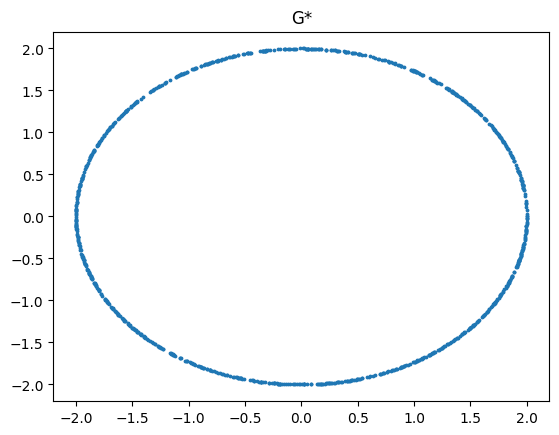

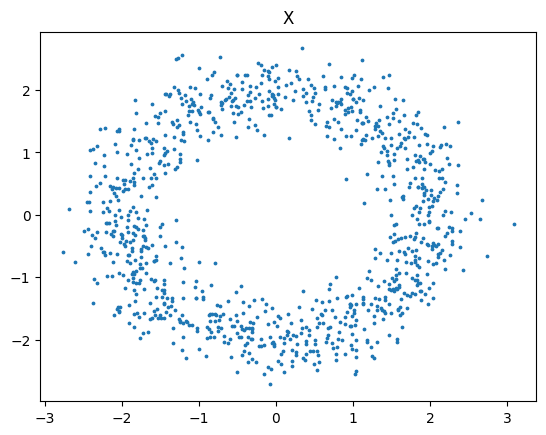

In [3]:
n=1000
x_orig, y_orig = generate_circular(n, 2)

plt.scatter(x_orig, y_orig, s=3)
plt.title('G*')
plt.show()

x = x_orig + np.random.normal(loc=0.0, scale=0.3, size=n)
y = y_orig + np.random.normal(loc=0.0, scale=0.3, size=n)

plt.scatter(x, y, s=3)
plt.title('X')
plt.show()

In [4]:
data = torch.stack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)],dim=1)

In [20]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,2),
)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters())
diffusion = Diffusion(data, 100,
                 0.0001, 0.1, 'linear',
                 model, loss, optimizer)

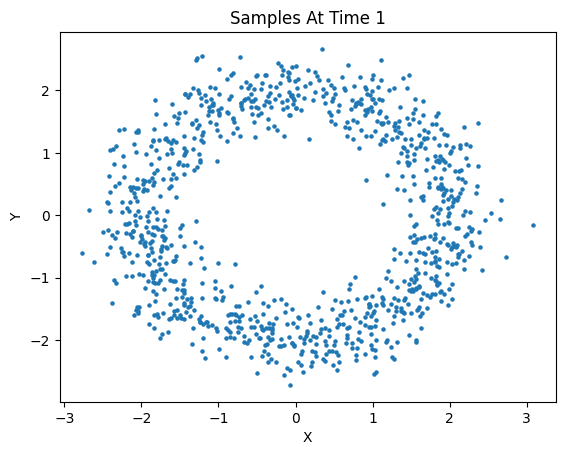

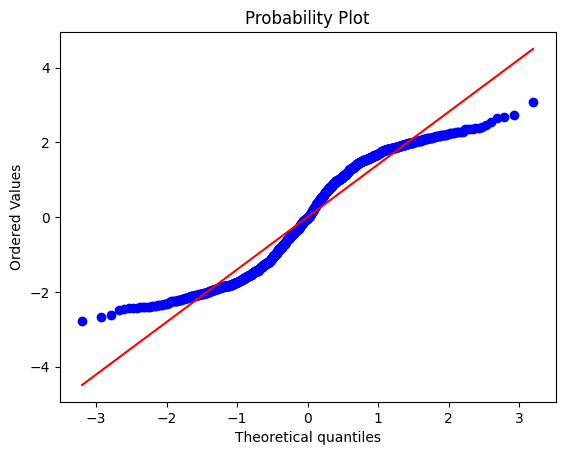

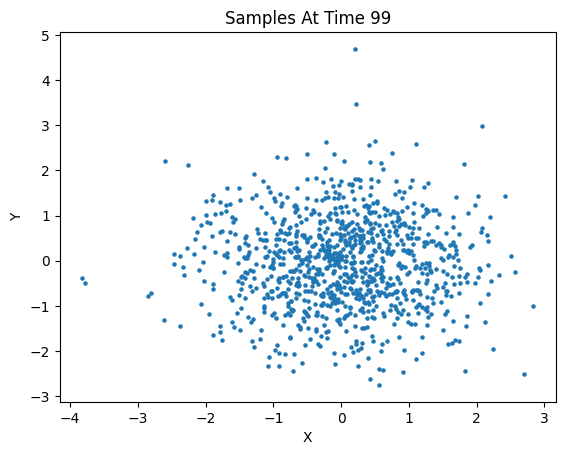

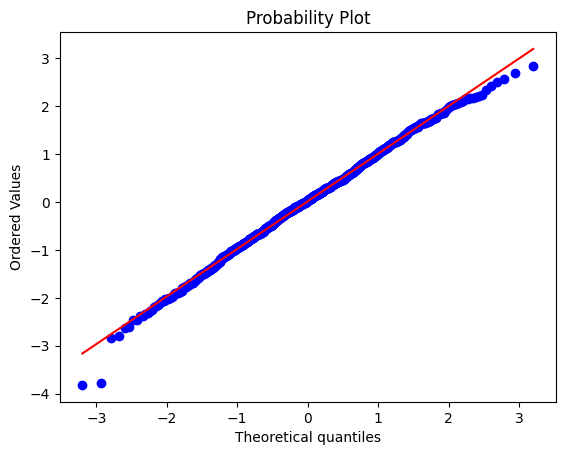

In [6]:
noised = diffusion.forward(1, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(99, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

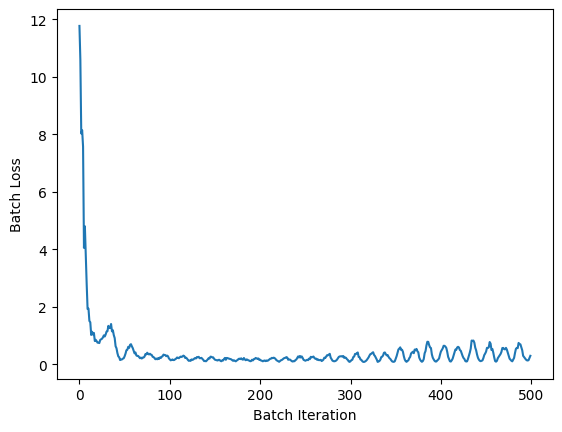

In [44]:
diffusion.train(100, 30)

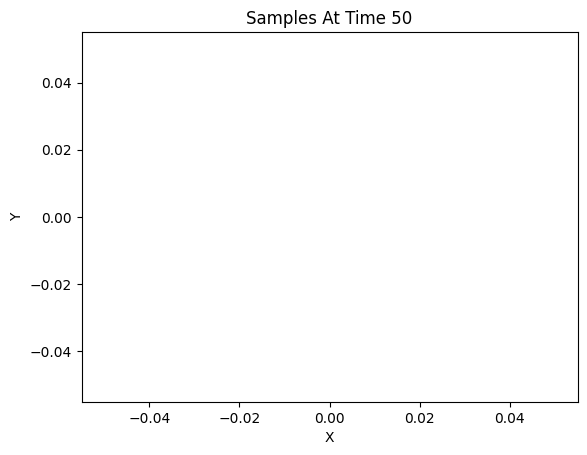

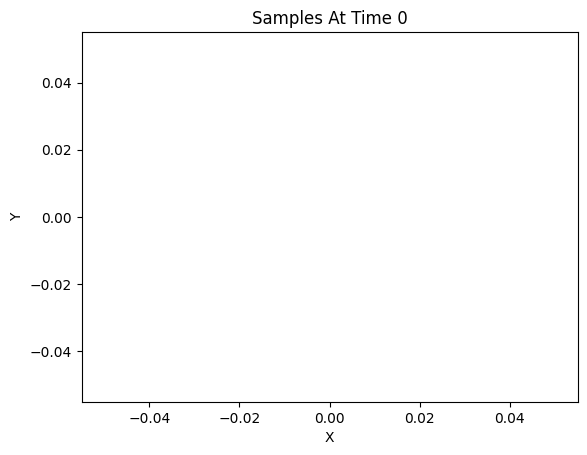

In [38]:
new_x = diffusion.sample(1000, 50)

In [39]:
new_x[95000]

tensor([-1.0207e+08,  2.3754e+06])

In [56]:
diffusion.model(torch.tensor([0, 0 , 0], dtype=torch.float))

tensor([0.3084, 0.4523], grad_fn=<AddBackward0>)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)
def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq
def sample_batch(size, noise=0.3):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

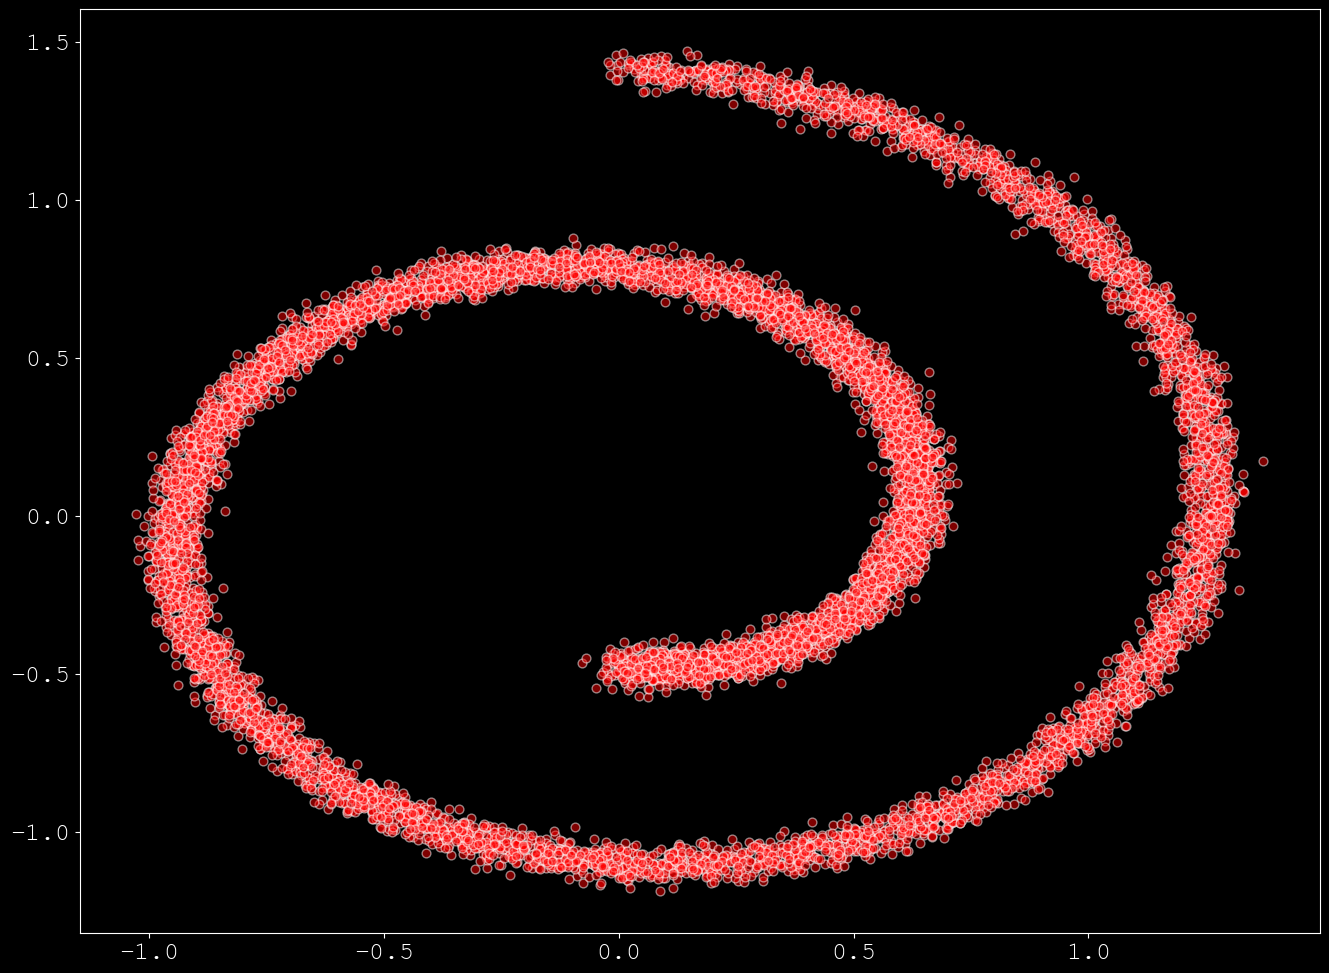

In [16]:
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40);

In [20]:
# Create schedule
betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=1e-5, end=1e-2)
# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [ ]:
n_steps = 100
model = ConditionalModel(n_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
# Create EMA model
#ema = EMA(0.9)
#ema.register(model)
# Batch size
batch_size = 128
for t in range(2001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        #ema.update(model)
    # Print loss
    if (t % 200 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

tensor(0.9255, grad_fn=<MeanBackward0>)
tensor(0.7734, grad_fn=<MeanBackward0>)
tensor(0.4747, grad_fn=<MeanBackward0>)
